In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [20]:
def analyze_ev_log(log_path="GreedyActionEVLog.csv"):
    base_dir = os.path.join("..", "data", "action_logs")
    actions_path = os.path.join(base_dir, "GreedyActionEVLog.csv")
    df = pd.read_csv(actions_path)
    df = df[df["action_type"].notna()].copy()

    df["payout"] = None

    summary = df.groupby("action_type").agg(
        times_chosen=("action_type", "count"),
        avg_ev=("ev", "mean"),
        median_ev=("ev", "median"),
        std_ev=("ev", "std"),
        max_ev=("ev", "max"),
        min_ev=("ev", "min")
    ).reset_index()

    summary["usage_percent"] = 100 * summary["times_chosen"] / summary["times_chosen"].sum()
    summary["var_ev"] = summary["std_ev"] ** 2

    avg_payout_lookup = {
        "game_bet": 1.478,
        "move_camel": 1.00,
        "move_trap": 1.4492,
        "round_winner_bet": 1.451
    }
    summary["avg_actual_payout"] = summary["action_type"].map(avg_payout_lookup)

    summary = summary[[
        "action_type", "usage_percent", "times_chosen",
        "avg_ev", "median_ev", "std_ev", "var_ev", 
        "max_ev", "min_ev", "avg_actual_payout"
    ]]

    return df, summary

df, summary = analyze_ev_log("GreedyActionEVLog.csv")

summary




,action_type,usage_percent,times_chosen,avg_ev,median_ev,std_ev,var_ev,max_ev,min_ev,avg_actual_payout
0,game_bet,23.936572,1902,1.485652,1.24875,0.837996,0.702237,8.000,0.75125,1.4780
1,move_camel,26.025673,2068,0.750000,0.75000,0.000000,0.000000,0.750,0.75000,1.0000
2,move_trap,8.935313,710,1.451544,1.25600,0.777690,0.604802,6.084,0.75200,1.4492
3,round_winner_bet,41.102441,3266,1.446508,1.18500,0.743061,0.552140,5.000,0.75000,1.4510


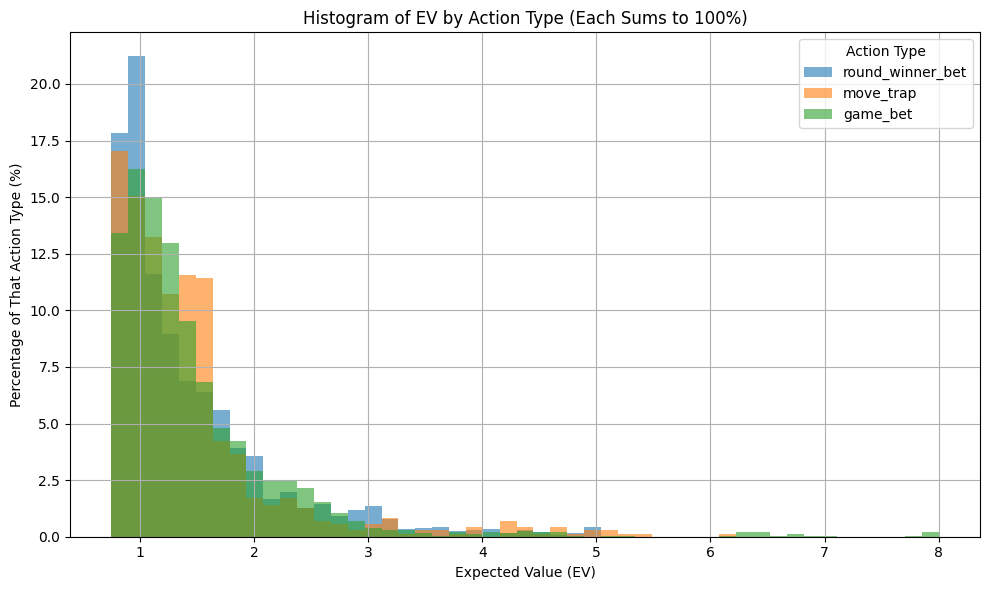

In [21]:
plt.figure(figsize=(10, 6))

bins = np.linspace(df["ev"].min(), df["ev"].max(), 50)

for action_type in df["action_type"].unique():
    if action_type == "move_camel":
        continue
    ev_values = df[df["action_type"] == action_type]["ev"]
    
    weights = np.ones_like(ev_values) * (100.0 / len(ev_values))

    plt.hist(ev_values, bins=bins, weights=weights, alpha=0.6, label=action_type)

plt.title("Histogram of EV by Action Type (Each Sums to 100%)")
plt.xlabel("Expected Value (EV)")
plt.ylabel("Percentage of That Action Type (%)")
plt.legend(title="Action Type")
plt.grid(True)
plt.tight_layout()
plt.show()



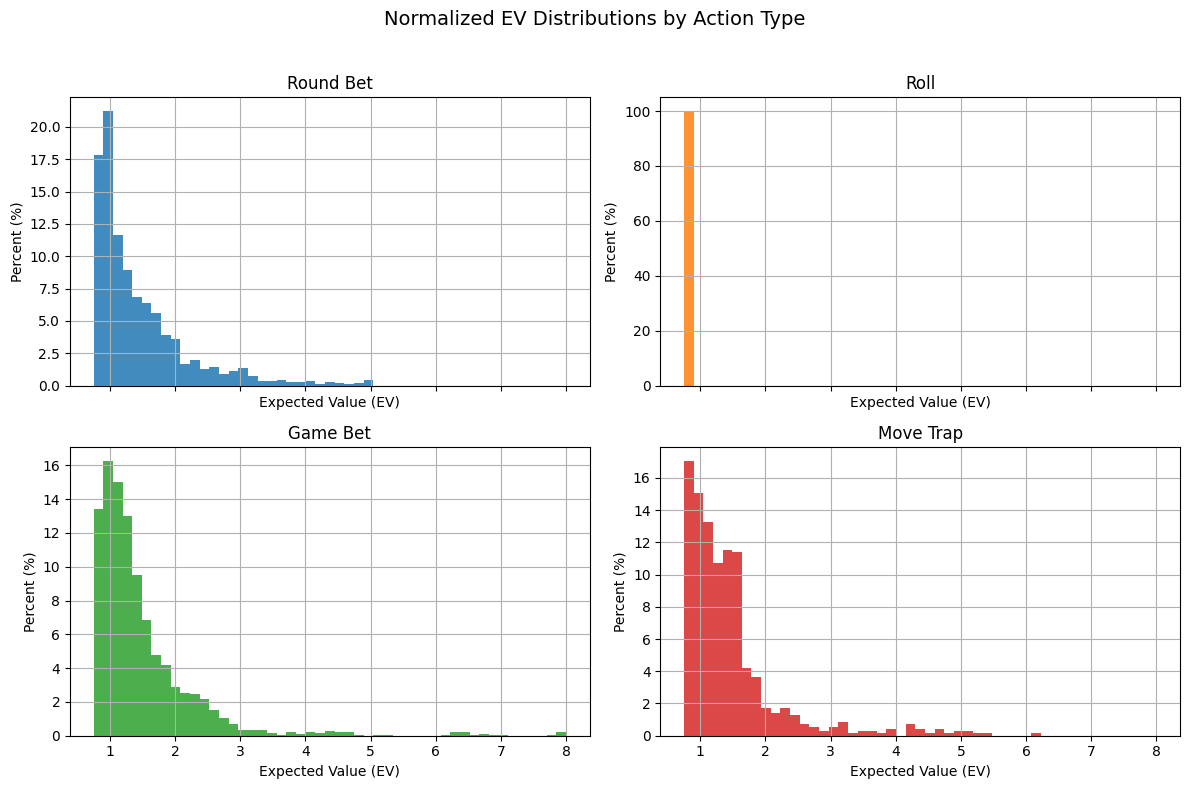

In [22]:
action_labels = {
    "round_winner_bet": "Round Bet",
    "move_camel": "Roll",
    "game_bet": "Game Bet",
    "move_trap": "Move Trap"
}

bins = np.linspace(df["ev"].min(), df["ev"].max(), 50)
action_types = list(action_labels.keys())

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)
axes = axes.flatten()  

for i, action_type in enumerate(action_types):
    ax = axes[i]
    ev_values = df[df["action_type"] == action_type]["ev"]
    weights = np.ones_like(ev_values) * (100.0 / len(ev_values))
    
    ax.hist(ev_values, bins=bins, weights=weights, alpha=0.85, color=f'C{i}')
    ax.set_title(f"{action_labels[action_type]}", fontsize=12)
    ax.set_ylabel("Percent (%)")
    ax.set_xlabel("Expected Value (EV)")
    ax.grid(True)

for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.suptitle("Normalized EV Distributions by Action Type", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



In [23]:
base_dir = os.path.join("..", "data", "action_logs")
actions_path = os.path.join(base_dir, "GreedyActionEVLog.csv")
df = pd.read_csv(actions_path)  

df = df[df["action_type"].notna()].copy()
df["turn_number"] = df.groupby("game_id").cumcount() + 1
df["is_camel_move"] = df["action_type"] == "move_camel"
df["camel_move_count"] = df.groupby("game_id")["is_camel_move"].cumsum()
df["round_number"] = (df["camel_move_count"] // 5) + 1
avg_turn_by_action = df.groupby("action_type")["turn_number"].mean().reset_index(name="avg_turn_number")
avg_round_by_action = df.groupby("action_type")["round_number"].mean().reset_index(name="avg_round_number")
summary = pd.merge(avg_turn_by_action, avg_round_by_action, on="action_type")

print("Meta Stats by Action Type:")
display(summary)

#average times per game, average times per round


Meta Stats by Action Type:


,action_type,avg_turn_number,avg_round_number
0,game_bet,32.347529,1.939012
1,move_camel,47.420696,2.884429
2,move_trap,37.292958,2.442254
3,round_winner_bet,43.710349,2.774342


In [24]:
base_dir = os.path.join("..", "data", "action_logs")
actions_path = os.path.join(base_dir, "GreedyActionEVLog.csv")
df = pd.read_csv(actions_path)

game_bets = df[df["action_type"] == "game_bet"].copy()

def get_camel_location(row):
    camel_id = row["camel"]  # c_0
    return row[f"camel_{camel_id}_location"]

game_bets["camel_location"] = game_bets.apply(get_camel_location, axis=1)

game_bets["bet_target"] = game_bets["bet_type"]

camel_position_stats = game_bets.groupby("bet_target")["camel_location"].agg(
    avg_location="mean",
    min_location="min",
    max_location="max"
).reset_index()

print("Game Bet Camel Position Stats:")
display(camel_position_stats)


Game Bet Camel Position Stats:


,bet_target,avg_location,min_location,max_location
0,lose,2.692308,0,13
1,win,6.360248,2,14


In [25]:
base_dir = os.path.join("..", "data", "action_logs")
actions_path = os.path.join(base_dir, "GreedyActionEVLog.csv")
df = pd.read_csv(actions_path) 
df = df[df["action_type"].notna()].copy()

df["turn_number"] = df.groupby("game_id").cumcount() + 1
df["is_camel_move"] = df["action_type"] == "move_camel"
df["camel_move_count"] = df.groupby("game_id")["is_camel_move"].cumsum()

df["round_number"] = (df["camel_move_count"] // 5) + 1

game_lengths = df.groupby("game_id")["turn_number"].max()
avg_game_length = game_lengths.mean()
min_game_length = game_lengths.min()
max_game_length = game_lengths.max()

round_counts = df.groupby("game_id")["round_number"].max()
avg_rounds_per_game = round_counts.mean()
min_rounds_per_game = round_counts.min()
max_rounds_per_game = round_counts.max()

print(f"Average Game Length: {avg_game_length:.2f} turns")
print(f"Min Game Length: {min_game_length} turns")
print(f"Max Game Length: {max_game_length} turns\n")

print(f"Average Rounds per Game: {avg_rounds_per_game:.2f}")
print(f"Min Rounds per Game: {min_rounds_per_game}")
print(f"Max Rounds per Game: {max_rounds_per_game}")


Average Game Length: 79.46 turns
Min Game Length: 40 turns
Max Game Length: 123 turns

Average Rounds per Game: 4.74
Min Rounds per Game: 2
Max Rounds per Game: 8


In [26]:
games_per_player = df.groupby("active_player")["game_id"].nunique().to_dict()

rounds_per_game = df.groupby("game_id")["round_number"].max()
avg_rounds_per_game = rounds_per_game.mean()

summary = df.groupby(["active_player", "action_type"]).agg(
    avg_turn_number=("turn_number", "mean"),
    avg_round_number=("round_number", "mean"),
    total_count=("action_type", "count")
).reset_index()

summary["avg_times_per_game"] = summary.apply(
    lambda row: row["total_count"] / games_per_player.get(row["active_player"], 1),
    axis=1
)
summary["avg_times_per_round"] = summary["avg_times_per_game"] / avg_rounds_per_game

print("Meta Stats by Action Type (Per Player):")
display(summary)


Meta Stats by Action Type (Per Player):


,active_player,action_type,avg_turn_number,avg_round_number,total_count,avg_times_per_game,avg_times_per_round
0,0.0,game_bet,32.534884,1.951374,473,4.73,0.997890
1,0.0,move_camel,45.804511,2.787594,532,5.32,1.122363
2,0.0,move_trap,26.115646,1.891156,147,1.47,0.310127
3,0.0,round_winner_bet,44.302752,2.821101,872,8.72,1.839662
4,1.0,game_bet,32.184874,1.939076,476,4.76,1.004219
5,1.0,move_camel,47.005629,2.868668,533,5.33,1.124473
6,1.0,move_trap,37.899497,2.552764,199,1.99,0.419831
7,1.0,round_winner_bet,43.207643,2.737580,785,7.85,1.656118
8,2.0,game_bet,32.176471,1.915966,476,4.76,1.004219
9,2.0,move_camel,50.728814,3.027542,472,4.72,0.995781


In [27]:
games_per_player = df.groupby("active_player")["game_id"].nunique().to_dict()

rounds_per_game = df.groupby("game_id")["round_number"].max()
avg_rounds_per_game = rounds_per_game.mean()

player_summary = df.groupby(["active_player", "action_type"]).agg(
    avg_turn_number=("turn_number", "mean"),
    avg_round_number=("round_number", "mean"),
    total_count=("action_type", "count")
).reset_index()

player_summary["avg_times_per_game"] = player_summary.apply(
    lambda row: row["total_count"] / games_per_player.get(row["active_player"], 1),
    axis=1
)
player_summary["avg_times_per_round"] = player_summary["avg_times_per_game"] / avg_rounds_per_game

summary_avg = player_summary.groupby("action_type").agg({
    "avg_turn_number": "mean",
    "avg_round_number": "mean",
    "avg_times_per_game": "mean",
    "avg_times_per_round": "mean"
}).reset_index()

print("Average Meta Stats per Action (Averaged Across Players):")
display(summary_avg)


Average Meta Stats per Action (Averaged Across Players):


,action_type,avg_turn_number,avg_round_number,avg_times_per_game,avg_times_per_round
0,game_bet,32.347747,1.939025,4.755,1.003165
1,move_camel,47.513740,2.888465,5.170,1.090717
2,move_trap,36.746777,2.413557,1.775,0.374473
3,round_winner_bet,43.731081,2.774554,8.165,1.722574


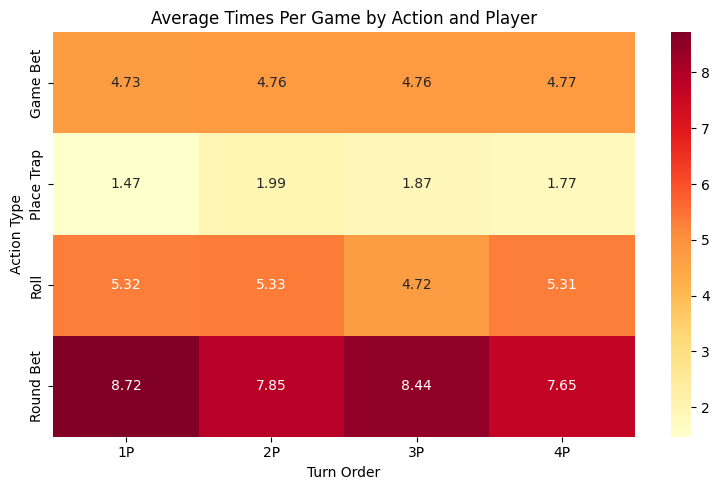

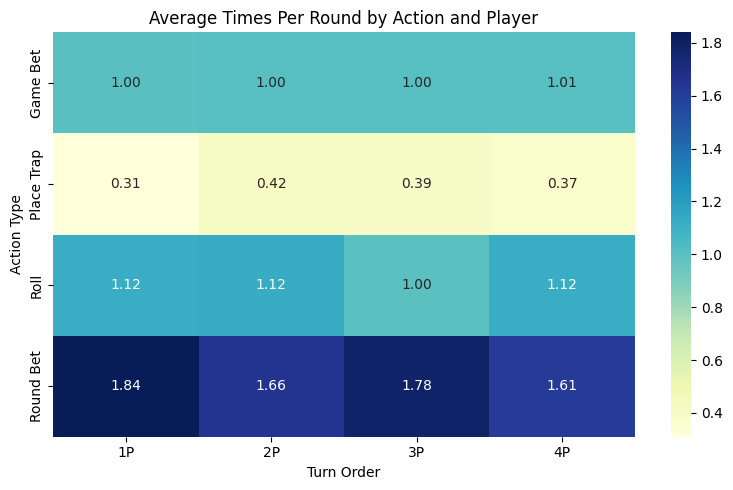

In [28]:
rounds_per_game = df.groupby("game_id")["round_number"].max()
avg_rounds_per_game = rounds_per_game.mean()

player_summary = df.groupby(["active_player", "action_type"]).agg(
    total_count=("action_type", "count")
).reset_index()

player_summary["avg_times_per_game"] = player_summary.apply(
    lambda row: row["total_count"] / games_per_player.get(row["active_player"], 1),
    axis=1
)
player_summary["avg_times_per_round"] = player_summary["avg_times_per_game"] / avg_rounds_per_game

action_labels = {
    "game_bet": "Game Bet",
    "move_camel": "Roll",
    "move_trap": "Place Trap",
    "round_winner_bet": "Round Bet"
}
player_summary["action_label"] = player_summary["action_type"].map(action_labels)
player_summary["player_label"] = player_summary["active_player"].apply(lambda x: f"{int(x)+1}P")

heatmap_game = player_summary.pivot(index="action_label", columns="player_label", values="avg_times_per_game")
heatmap_round = player_summary.pivot(index="action_label", columns="player_label", values="avg_times_per_round")

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_game, annot=True, fmt=".2f", cmap="YlOrRd")
plt.title("Average Times Per Game by Action and Player")
plt.xlabel("Turn Order")
plt.ylabel("Action Type")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_round, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Average Times Per Round by Action and Player")
plt.xlabel("Turn Order")
plt.ylabel("Action Type")
plt.tight_layout()
plt.show()


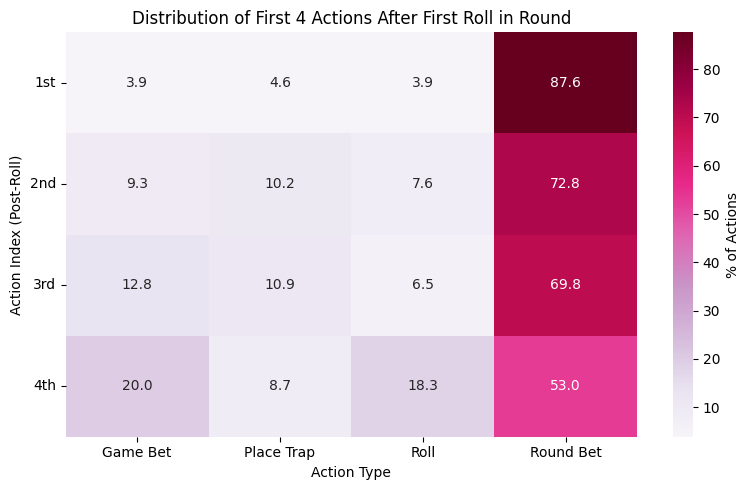

In [29]:
df = df.sort_values(by=["game_id", "round_number", "turn_number"]).copy()
df["first_roll"] = df["is_camel_move"] & (df.groupby(["game_id", "round_number"])["is_camel_move"].cumsum() == 1)
df["post_roll_action_index"] = -1
first_roll_idx = df[df["first_roll"]].index

for idx in first_roll_idx:
    game = df.at[idx, "game_id"]
    rnd = df.at[idx, "round_number"]
    subsequent_mask = (df["game_id"] == game) & (df["round_number"] == rnd) & (df.index > idx)
    df.loc[subsequent_mask, "post_roll_action_index"] = df.loc[subsequent_mask].groupby(["game_id", "round_number"]).cumcount() + 1

filtered = df[df["post_roll_action_index"].between(1, 4)].copy()

filtered["action_label"] = filtered["action_type"].map({
    "game_bet": "Game Bet",
    "move_camel": "Roll",
    "move_trap": "Place Trap",
    "round_winner_bet": "Round Bet"
})

heatmap_pos = (
    filtered
    .groupby(["post_roll_action_index", "action_label"])
    .size()
    .unstack(fill_value=0)
)

heatmap_pos_percent = heatmap_pos.div(heatmap_pos.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_pos_percent, annot=True, fmt=".1f", cmap="PuRd", cbar_kws={"label": "% of Actions"})
plt.title("Distribution of First 4 Actions After First Roll in Round")
plt.xlabel("Action Type")
plt.ylabel("Action Index (Post-Roll)")
plt.yticks([0.5, 1.5, 2.5, 3.5], ["1st", "2nd", "3rd", "4th"], rotation=0)
plt.tight_layout()
plt.show()


/var/folders/s1/yr6shryj0cj4_tjfrj721hgc0000gn/T/ipykernel_51594/3969620763.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  heatmap_data = df.groupby(["game_phase", "action_label"]).size().unstack(fill_value=0)


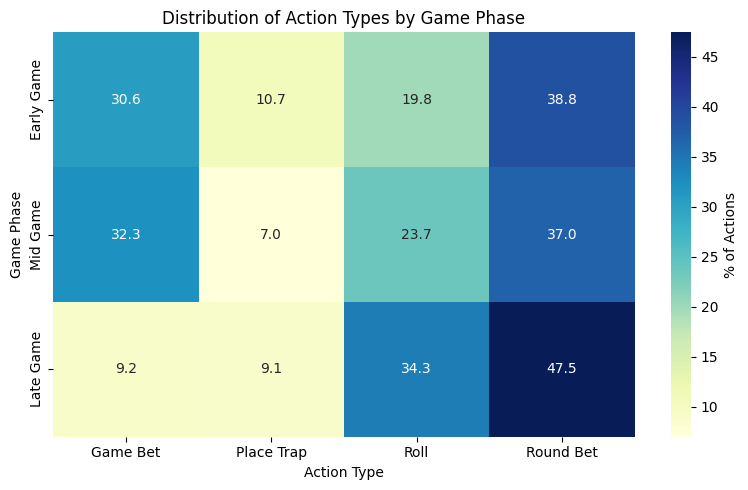

In [30]:
df["action_label"] = df["action_type"].map({
    "game_bet": "Game Bet",
    "move_camel": "Roll",
    "move_trap": "Place Trap",
    "round_winner_bet": "Round Bet"
})
df = df[df["action_label"].notna()].copy()

turns_per_game = df.groupby("game_id")["turn_number"].max()
df = df.merge(turns_per_game.rename("total_turns"), on="game_id")

def assign_phase(row):
    if row["turn_number"] <= row["total_turns"] / 3:
        return "Early Game"
    elif row["turn_number"] <= 2 * row["total_turns"] / 3:
        return "Mid Game"
    else:
        return "Late Game"

df["game_phase"] = df.apply(assign_phase, axis=1)

phase_order = ["Early Game", "Mid Game", "Late Game"]
df["game_phase"] = pd.Categorical(df["game_phase"], categories=phase_order, ordered=True)

heatmap_data = df.groupby(["game_phase", "action_label"]).size().unstack(fill_value=0)
heatmap_percent = heatmap_data.div(heatmap_data.sum(axis=1), axis=0) * 100

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_percent, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={"label": "% of Actions"})
plt.title("Distribution of Action Types by Game Phase")
plt.xlabel("Action Type")
plt.ylabel("Game Phase")
plt.tight_layout()
plt.show()


In [31]:
games_per_player = df.groupby("active_player")["game_id"].nunique().to_dict()

rounds_per_game = df.groupby("game_id")["round_number"].max()
avg_rounds_per_game = rounds_per_game.mean()

player_summary = df.groupby(["active_player", "action_type"]).agg(
    avg_turn_number=("turn_number", "mean"),
    avg_round_number=("round_number", "mean"),
    total_count=("action_type", "count")
).reset_index()

player_summary["avg_times_per_game"] = player_summary.apply(
    lambda row: row["total_count"] / games_per_player.get(row["active_player"], 1),
    axis=1
)
player_summary["avg_times_per_round"] = player_summary["avg_times_per_game"] / avg_rounds_per_game

summary_avg = player_summary.groupby("action_type").agg({
    "avg_turn_number": "mean",
    "avg_round_number": "mean",
    "avg_times_per_game": "mean",
    "avg_times_per_round": "mean"
}).reset_index()

average_evs = {
    "game_bet": 1.49,
    "move_camel": 0.75,
    "move_trap": 1.45,
    "round_winner_bet": 1.45
}

summary_avg["avg_ev"] = summary_avg["action_type"].map(average_evs)
summary_avg["expected_ev_per_game"] = summary_avg["avg_times_per_game"] * summary_avg["avg_ev"]

print("Summary Table (Averaged Across Players):")
print(summary_avg)



Summary Table (Averaged Across Players):
        action_type  avg_turn_number  avg_round_number  avg_times_per_game  \
0          game_bet        32.347747          1.939025               4.755   
1        move_camel        47.513740          2.888465               5.170   
2         move_trap        36.746777          2.413557               1.775   
3  round_winner_bet        43.731081          2.774554               8.165   

   avg_times_per_round  avg_ev  expected_ev_per_game  
0             1.003165    1.49               7.08495  
1             1.090717    0.75               3.87750  
2             0.374473    1.45               2.57375  
3             1.722574    1.45              11.83925  


In [32]:
final_turns = df.groupby("game_id")["turn_number"].max().reset_index()
df_final_turns = df.merge(final_turns, on=["game_id", "turn_number"])

coin_columns = [f"player_{i}_coins" for i in range(4)]
coins_long = df_final_turns[["game_id"] + coin_columns].melt(
    id_vars="game_id",
    var_name="player",
    value_name="coins"
)

avg_coins_all_players = coins_long["coins"].mean()
avg_coins_all_players

25.8475

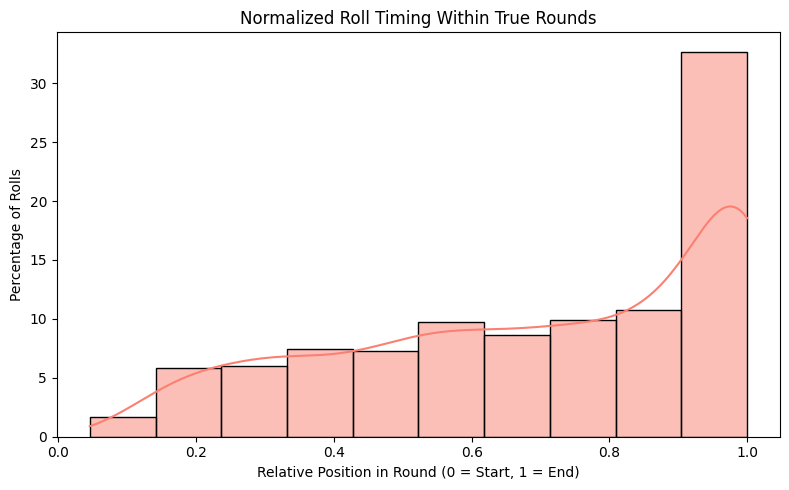

In [33]:
base_dir = os.path.join("..", "data", "action_logs")
actions_path = os.path.join(base_dir, "GreedyActionEVLog.csv")
df = pd.read_csv(actions_path) 
df = df[df["action_type"].notna()].copy()
df["turn_number"] = df.groupby("game_id").cumcount() + 1
df = df.sort_values(by=["game_id", "turn_number"]).reset_index(drop=True)

df["true_round_number"] = -1
current_rounds = {}
rolled_camels = {}

for idx, row in df.iterrows():
    game = row["game_id"]
    if game not in current_rounds:
        current_rounds[game] = 1
        rolled_camels[game] = set()

    df.at[idx, "true_round_number"] = current_rounds[game]

    if row["action_type"] == "move_camel":
        camel_id = row["camel"]
        rolled_camels[game].add(camel_id)

        if len(rolled_camels[game]) == 5:
            current_rounds[game] += 1
            rolled_camels[game] = set()

df["round_action_index"] = df.groupby(["game_id", "true_round_number"]).cumcount() + 1

action_counts = df.groupby(["game_id", "true_round_number"])["action_type"].count().reset_index(name="actions_in_round")
df = df.merge(action_counts, on=["game_id", "true_round_number"])

df["relative_round_position"] = (df["round_action_index"] - 1) / (df["actions_in_round"] - 1)

rolls = df[df["action_type"] == "move_camel"]

plt.figure(figsize=(8, 5))
sns.histplot(rolls["relative_round_position"], bins=10, stat="percent", kde=True, color="salmon")
plt.title("Normalized Roll Timing Within True Rounds")
plt.xlabel("Relative Position in Round (0 = Start, 1 = End)")
plt.ylabel("Percentage of Rolls")
plt.tight_layout()
plt.show()


In [34]:
base_dir = os.path.join("..", "data", "action_logs")
actions_path = os.path.join(base_dir, "GreedyActionEVLog.csv")
df_full = pd.read_csv(actions_path) 
df_full = df_full[df_full["action_type"].notna()].copy()
df_full = df_full.sort_values(by=["game_id"]).reset_index(drop=True)

df_full["turn_number"] = df_full.groupby("game_id").cumcount() + 1

df_full["true_round_number"] = -1
current_rounds = {}
rolled_camels = {}

for idx, row in df_full.iterrows():
    game = row["game_id"]
    if game not in current_rounds:
        current_rounds[game] = 1
        rolled_camels[game] = set()

    df_full.at[idx, "true_round_number"] = current_rounds[game]

    if row["action_type"] == "move_camel":
        camel_id = row["camel"]
        rolled_camels[game].add(camel_id)
        if len(rolled_camels[game]) == 5:
            current_rounds[game] += 1
            rolled_camels[game] = set()

df_full["round_action_index"] = df_full.groupby(["game_id", "true_round_number"]).cumcount() + 1

traps = df_full[df_full["action_type"] == "move_trap"].copy()

def count_hit_camels(row):
    trap_loc = row["trap_location"]
    return sum(1 for i in range(5) if row.get(f"camel_c_{i}_location", -999) < trap_loc)

def trap_ahead_of_leader(row):
    trap_loc = row["trap_location"]
    lead_pos = max(row[f"camel_c_{i}_location"] for i in range(5))
    return trap_loc - lead_pos

traps["camels_behind_trap"] = traps.apply(count_hit_camels, axis=1)
traps["distance_ahead_of_leader"] = traps.apply(trap_ahead_of_leader, axis=1)

def trap_stats(subset, label):
    return {
        "Trap Type": label,
        "% of Traps": len(subset) / len(traps) * 100,
        "Avg Camels Behind": subset["camels_behind_trap"].mean(),
        "Avg Distance Ahead": subset["distance_ahead_of_leader"].mean(),
        "Avg Round Action Index": subset["round_action_index"].mean()
    }

plus = traps[traps["trap_type"] == 1]
minus = traps[traps["trap_type"] == -1]
summary = pd.DataFrame([
    trap_stats(plus, "+1 Trap"),
    trap_stats(minus, "-1 Trap"),
    trap_stats(traps, "All Traps")
])

display(summary)

,Trap Type,% of Traps,Avg Camels Behind,Avg Distance Ahead,Avg Round Action Index
0,+1 Trap,40.985915,4.749141,2.453608,11.546392
1,-1 Trap,59.014085,4.763723,1.551313,14.116945
2,All Traps,100.000000,4.757746,1.921127,13.063380
